*A notebook comparing eigenstrat pca estimates to sklearn ...*

# Imports

In [28]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

import pcshrink

# Data prep

In [29]:
%%time
data = pcshrink.UnpackedAncestryMap("/project/jnovembre/jhmarcus/ancient-sardinia/data/ref_genotypes/7-11-2018/lazaridis_2014/data_fil")

CPU times: user 7.05 s, sys: 2.26 s, total: 9.31 s
Wall time: 3.57 s


In [30]:
print(data.n, data.p)

777 594924


Find snps that are too rare or too common

In [110]:
# use allele frequency estimator from Price et al. 2006
f = (1. + np.nansum(data.Y, axis=1)) / (2 + (2. * data.n))

# keep snps that aren't too rare or common
snp_idx = np.where((f > .02) & (f < .98))[0]
print(f.shape, snp_idx.shape)

(594924,) (426765,)


Mean center and scale and impute missing values to 0

In [ ]:
Z = data.Y[snp_idx, :]

# mean genotype 
mu = np.nanmean(Z, axis=1).reshape(len(snp_idx), 1)

# empirical std deviation
std = np.nanstd(Z, axis=1).reshape(len(snp_idx), 1)

# heterozygosity scaler
het = np.sqrt(2. * f[snp_idx] * (1. - f[snp_idx])).reshape(len(snp_idx), 1)

Z = (Z - mu) / het
Z[np.isnan(Z)] = 0.0

Text(0,0.5,'Emprical Std')

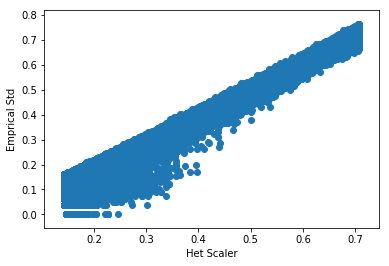

In [124]:
plt.scatter(het, std)
plt.xlabel("Het Scaler")
plt.ylabel("Emprical Std")

# PCA

In [177]:
%%time
pca = PCA(data.n, svd_solver="full")
pca.fit(Z.T)

CPU times: user 2min 35s, sys: 15.7 s, total: 2min 51s
Wall time: 9.42 s


snp weights

In [162]:
F_hat = pca.components_.T
F_hat.shape

(445953, 777)

coordinates 

In [163]:
L = (F_hat.T @ Z).T 
L = L / np.linalg.norm(L, axis=0, ord=2)

Plot PC1 vs PC2

Text(0,0.5,'PC2')

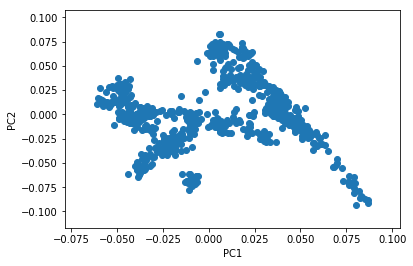

In [164]:
plt.scatter(L[:, 0], -L[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")

Read eigenvectors from output from eigenstrat run with these params ...

In [165]:
%%bash
cat data/pca.par

genotypename:   data_fil.geno
snpname:    data_fil.snp
indivname:  data_fil.ind
evecoutname:    data_fil.evec
evaloutname:    data_fil.eval
snpweightoutname:   data_fil.weights
outlieroutname: data_fil.outliers
numoutlieriter: 0
altnormstyle:   NO
missingmode:    NO
ldregress:  0
noxdata:    YES
nomalexhet: YES
numoutevec: 20


In [166]:
pc_df = pd.read_table("./data/data_fil.evec", header=None, sep="\t", skiprows=1)[0].str.lstrip().str.split(expand=True)

Convert pc_df to matrix

In [167]:
L_eigen = pc_df.iloc[:,1:21].astype(float).as_matrix()

/project/jnovembre/jhmarcus/src/miniconda3/envs/pcshrink_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


Text(0,0.5,'PC2')

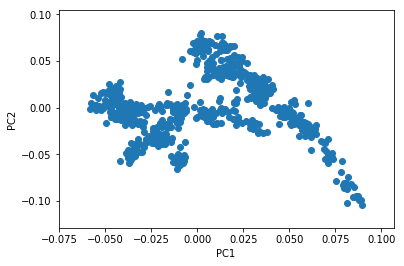

In [168]:
plt.scatter(-L_eigen[:,0], -L_eigen[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")

Compare sklearn to eigenstrat ...

Text(0,0.5,'PC1 (eigenstrat)')

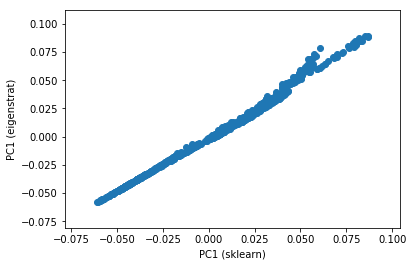

In [169]:
plt.scatter(L[:,0], -L_eigen[:,0])
plt.xlabel("PC1 (sklearn)")
plt.ylabel("PC1 (eigenstrat)")

Text(0,0.5,'PC2 (eigenstrat)')

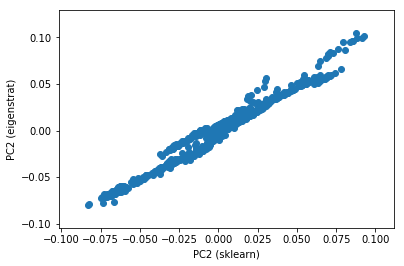

In [170]:
plt.scatter(L[:,1], L_eigen[:,1])
plt.xlabel("PC2 (sklearn)")
plt.ylabel("PC2 (eigenstrat)")

Text(0,0.5,'PC3 (eigenstrat)')

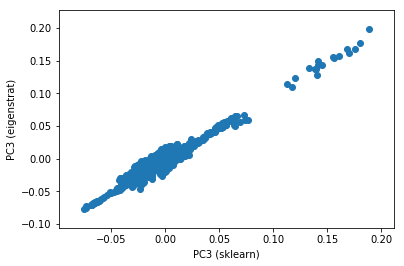

In [171]:
plt.scatter(L[:,2], -L_eigen[:,2])
plt.xlabel("PC3 (sklearn)")
plt.ylabel("PC3 (eigenstrat)")

Text(0,0.5,'PC4 (eigenstrat)')

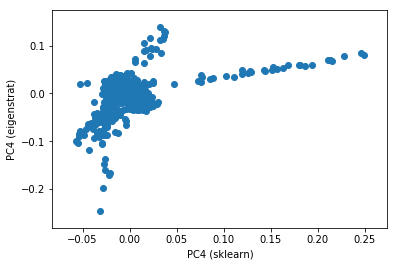

In [172]:
plt.scatter(L[:,3], -L_eigen[:,3])
plt.xlabel("PC4 (sklearn)")
plt.ylabel("PC4 (eigenstrat)")

The lower pcs look very different!

Now compare eigenvalues ...

/project/jnovembre/jhmarcus/src/miniconda3/envs/pcshrink_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


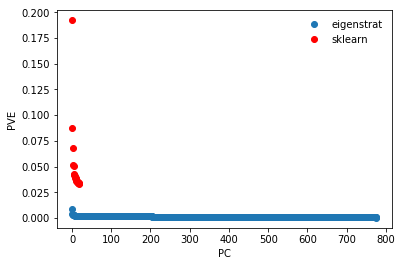

In [176]:
lamb_eigenstrat = pd.read_table("./data/data_fil.eval", header=None, sep="\t").as_matrix()
pves_eigenstrat = lamb_eigenstrat / np.sum(lamb_eigenstrat)

lamb_sklearn = pca.singular_values_**2
pves_sklearn = lamb / np.sum(lamb)

plt.plot(pves_eigenstrat, 'o', label="eigenstrat")
plt.plot(pves_sklearn, 'ro', label="sklearn")
plt.xlabel("PC")
plt.ylabel("PVE")
plt.legend(frameon=False)

Text(0,0.5,'pve (sklearn)')

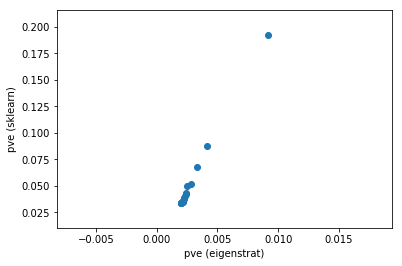

In [160]:
plt.scatter(pves_eigenstrat[:20], pves_sklearn)
plt.xlabel("pve (eigenstrat)")
plt.ylabel("pve (sklearn)")

The eigenvalues look very different!